In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_csv(os.path.join('data', 'train.csv'))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<AxesSubplot: >

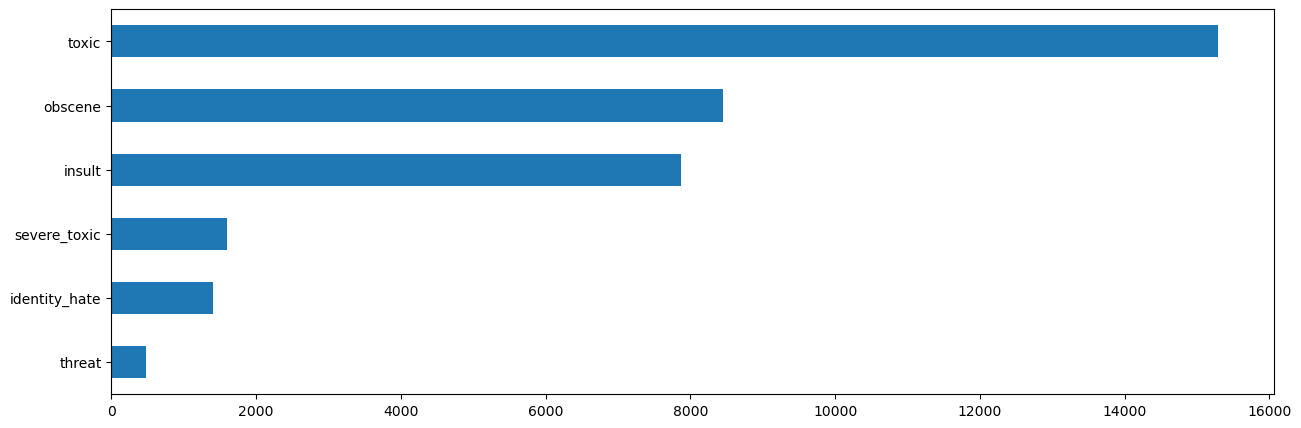

In [5]:
df[df.columns[2:]].sum().sort_values().plot(kind='barh', figsize=(15, 5))

<AxesSubplot: >

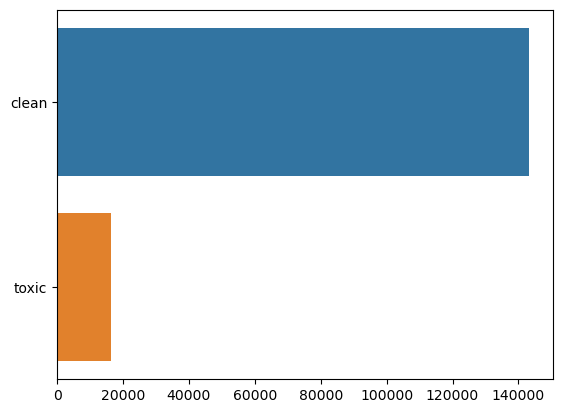

In [6]:
sns.barplot(x=[df[df[df.columns[2:]].sum(axis=1) == 0].shape[0], df[df[df.columns[2:]].sum(axis=1) > 0].shape[0]], y=['clean', 'toxic'])

### Tokenization

In [7]:
from transformers import BertTokenizerFast as BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

c:\Users\smitc\anaconda3\envs\ds2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
encoding = tokenizer.encode_plus(
  df['comment_text'][0],
  max_length=512,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\smitc\anaconda3\envs\ds2\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

### Dataset

In [9]:
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, validation_df.shape

((143613, 8), (15958, 8))

In [10]:
import torch
class ToxicDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, item):
    data = self.data[item]
    comment_text = data['comment_text']
    encoding = self.tokenizer.encode_plus(
      comment_text,
      max_length=self.max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding['input_ids'].flatten(),
      attention_mask=encoding['attention_mask'].flatten(),
      labels=torch.tensor(data[self.data.columns[2:]].values, dtype=torch.float)
    )

In [11]:
train_dataset = ToxicDataset(train_df, tokenizer, 512)
validation_dataset = ToxicDataset(validation_df, tokenizer, 512)

In [12]:
from transformers import BertForSequenceClassification
bert = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

### Model

In [13]:
class ToxicClassifier(torch.nn.Module):
  def __init__(self, n_classes):
    super(ToxicClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=n_classes)
    self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
    self.criteria = torch.nn.BCELoss()
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    return output

### Training

In [14]:
def train_epoch(model, data_loader, optimizer, device, scheduler=None):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['labels'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = model.criteria(outputs, labels)
    correct_predictions += torch.sum(torch.eq(outputs, labels))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if scheduler is not None:
      scheduler.step()
  return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [15]:
def eval_model(model, data_loader, device):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      labels = d['labels'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      loss = model.criteria(outputs, labels)
      correct_predictions += torch.sum(torch.eq(outputs, labels))
      losses.append(loss.item())
  return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [16]:
from collections import defaultdict
def train(model, train_data_loader, validation_data_loader, optimizer, device, scheduler=None, EPOCHS=5):
  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      optimizer,
      device,
      scheduler
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      validation_data_loader,
      device
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  plt.plot(history['train_acc'], label='train accuracy')
  plt.plot(history['val_acc'], label='validation accuracy')

  plt.title('Training history')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1])
  plt.savefig('train_history.png')
  plt.clf()



In [17]:
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxicClassifier(6).to(device)

EPOCHS = 10
BATCH_SIZE = 16
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=6)
validation_data_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=6)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [18]:
train(model, train_data_loader, validation_data_loader, optimizer, device, scheduler, EPOCHS)

Epoch 1/10
----------


### Test

In [ ]:
# Test the model

test_df = pd.read_csv('test.csv')
test_df.head()

class TestDataset:
  def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.comment_text = data.comment_text
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comment_text)
  
  def __getitem__(self, item):
    comment_text = str(self.comment_text[item])
    comment_text = " ".join(comment_text.split())

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding['input_ids'].flatten(),
      attention_mask=encoding['attention_mask'].flatten(),
    )

In [ ]:
test_dataset = TestDataset(test_df, tokenizer, 512)
test_data_loader = DataLoader(test_dataset, batch_size=16, num_workers=6)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d['comment_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.round(outputs)
      predictions.extend(preds)
      real_values.extend(d['labels'])
  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

### Results

In [ ]:
model = torch.load('best_model_state.bin')
y_pred, y_test = get_predictions(model, test_data_loader)
y_pred = y_pred.numpy()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score: ', auc)
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC curve')
plt.legend(loc='lower right')
plt.show()
plt.clf()

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test, y_pred, target_names=df.columns[2:])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=df.columns[2:], yticklabels=df.columns[2:])
plt.show()